In [1]:
estimator_name='mscn'

In [2]:
import pickle
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# dataset='census1a3'
# version='original'


def drawing(dataset,version,estimator_name):
    result_addr="./lecarb/estimator/mine/tree_inference_result/valid_"+dataset+"_"+version+".pkl"
    with open(result_addr, 'rb') as f:
        [inference_result,inference_time] = pickle.load(f)

    addr="./lecarb/estimator/predict_result/"+estimator_name+"_model_prediction/valid_"+dataset+"_"+version+".pkl"
    
    with open(addr, 'rb') as f:
        [prediction,label,data_length] = pickle.load(f)
        
        
    prediction=[prediction[i]/data_length for i in range(len(prediction))]


    count_prediction=[float(i) for i in prediction]

    prediction_values=sorted(Counter(count_prediction).keys(),key=lambda x:x,reverse=False)
#     label=np.around(label*data_length)

    

    loss=[] 
    t=[]
    mean_qerror=[]
    for threshold in prediction_values:
        add_time=0
        q_error=[]
        for i in range(len(prediction)):
            if prediction[i]<=threshold:
                q_error.append(1)
                add_time+=inference_time[i]
            else:
                p=np.around(prediction[i]*data_length)
                
                
                l=label[i]
                if p==0 and l==0:
                    q_error.append(1)
                elif p==0:
                    q_error.append(l)
                elif l==0:
                    q_error.append(p)
                else:
                    q_error.append(max(p/l,l/p))
        add_time=add_time*1000/10000
       
        loss.append(add_time+np.mean(q_error))
        t.append(add_time)
        mean_qerror.append(np.mean(q_error))
#     print("best eta:",prediction_values[loss.index(min(loss))])
    
#     threshold=prediction_values[loss.index(min(loss))]
#     add_time=0
#     q_error=[]
#     turn_to_precise=0
#     for i in range(len(prediction)):
#         if prediction[i]<=threshold:
#             turn_to_precise+=1
#             q_error.append(1)
#             add_time+=inference_time[i]
#         else:
#             p=np.around(prediction[i]*data_length)
#             l=label[i]
#             if p==0 and l==0:
#                 q_error.append(1)
#             elif p==0:
#                 q_error.append(l)
#             elif l==0:
#                 q_error.append(p)
#             else:
#                 q_error.append(max(p/l,l/p))
#     add_time=add_time*1000/10000
#     print("max:",np.max(q_error),'99th:',np.percentile(q_error,99),'95th:',np.percentile(q_error,95),'90th:',np.percentile(q_error,90),'75th:',np.percentile(q_error,75),'50th:',np.percentile(q_error,50),'25th:',np.percentile(q_error,25),'mean:',np.mean(q_error))
#     print("average time:",add_time,"ms/query")
#     print("turn_to_precise",turn_to_precise)
    
#     plt.xlabel('eta')
#     plt.ylabel('loss')
#     plt.plot(prediction_values,loss)
#     plt.show()
    
#     plt.xlabel('eta')
#     plt.ylabel('incremented time of using tree')
#     plt.plot(prediction_values,t)
#     plt.show()
    
#     plt.xlabel('eta')
#     plt.ylabel('mean q_error after using tree')
#     plt.plot(prediction_values,mean_qerror)
#     plt.show()
    
    return prediction_values,loss,t,mean_qerror

In [3]:
import numpy as np
from scipy.optimize import curve_fit,minimize
import matplotlib.pyplot as mpl

from sympy import symbols, diff
from sympy.functions import exp

def func1_for_diff(a,x0,sigma):
    x=symbols('x')
    f=a*exp(-(x-x0)**2/(2*sigma**2))
    derivative_f = diff(f, x)
    return f,derivative_f

def func2_for_diff(a,x0,sigma):
    x=symbols('x')
    f=a*exp(-(x-x0)**2/(2*sigma**2))+1
    derivative_f = diff(f, x)
    return f,derivative_f

# Let's create a function to model and create data
def func1(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def func2(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+1

def exponen(x,a,b,lamb):
    if type(x)==type([]):
        x=np.array(x)
    return a-b*np.exp(-(lamb*x))

def exponen_for_diff(a,b,lamb):
    x=symbols('x')
    f=a-b*exp(-(lamb*x))
    derivative_f = diff(f, x)
    return f,derivative_f

def fit2(x,y,fit_type):
    plt.plot(x, y, c='k', label='data')
    plt.scatter(x, y)
    if fit_type==1:
        popt, pcov = curve_fit(exponen, x, y,maxfev=1000000)
        ym = exponen(x, popt[0], popt[1], popt[2])
    elif fit_type==2:
        popt, pcov = curve_fit(func2, x, y,maxfev=1000000)
        ym = func2(x, popt[0], popt[1], popt[2])
    else:
        print("wrong type")
        return
        
    #popt returns the best fit values for parameters of the given model (func)

    plt.plot(x, ym, c='r', label='fit')
    plt.legend()
    plt.show()
    return popt

def exponent_func(a,b,lamb):
    f=lambda x:a-b*np.exp(-(lamb*x))
    return f

def func2_func(a,x0,sigma):
    f=lambda x:a*np.exp(-(x-x0)**2/(2*sigma**2))+1
    return f



In [4]:
def fit_and_find_best_eta(prediction_values,t,mean_qerror,rate):
    x=symbols('x')
    popt1=fit2(prediction_values,t,fit_type=1)
    popt2=fit2(prediction_values,mean_qerror,fit_type=2)
    f1,_=exponen_for_diff(popt1[0],popt1[1],popt1[2])
    f2,_=func2_for_diff(popt2[0],popt2[1],popt2[2])
    f=rate*f1+(1-rate)*f2
    print(f)
    print("-----------------")
    
    func_f1=exponent_func(popt1[0],popt1[1],popt1[2])
    func_f2=func2_func(popt2[0],popt2[1],popt2[2])
    func_f=lambda x:rate*func_f1(x)+(1-rate)*func_f2(x)
    result=minimize(func_f,x0=[0.5],method='SLSQP',bounds=[(0,1)])

    a=[i/10000 for i in range(0,10000)]
    b=[f.subs(x,i) for i in a]
    plt.plot(a,b)
    best_eta=result['x'][0]
    print("best eta:",best_eta)
#     print("loss:",f.subs(x,best_eta))
#     print("time:",f1.subs(x,best_eta))
#     print("mean_qerror:",f2.subs(x,best_eta))
    plt.scatter(result['x'][0],f.subs(x,result['x'][0]),color='r')
    plt.show()
    return best_eta


def test_for_best_eta(dataset,version,best_eta,estimator_name):
    result_addr="./lecarb/estimator/mine/tree_inference_result/valid_"+dataset+"_"+version+".pkl"
    with open(result_addr, 'rb') as f:
        [inference_result,inference_time] = pickle.load(f)

    addr="./lecarb/estimator/predict_result/"+estimator_name+"_model_prediction/valid_"+dataset+"_"+version+".pkl"
    
    with open(addr, 'rb') as f:
        [prediction,label,data_length] = pickle.load(f)
        
        
    prediction=[prediction[i]/data_length for i in range(len(prediction))]


    count_prediction=[float(i) for i in prediction]

    prediction_values=sorted(Counter(count_prediction).keys(),key=lambda x:x,reverse=False)  
#label=np.around(label*data_length)
    
    
    add_time=0
    q_error=[]
    turn_to_precise=0
    for i in range(len(prediction)):
        if prediction[i]<=best_eta:
            q_error.append(1)
            turn_to_precise+=1
            add_time+=inference_time[i]
        else:
            p=np.around(prediction[i]*data_length)
            l=label[i]
            if p==0 and l==0:
                q_error.append(1)
            elif p==0:
                q_error.append(l)
            elif l==0:
                q_error.append(p)
            else:
                q_error.append(max(p/l,l/p))
    add_time=add_time*1000/10000
    print("max:",np.max(q_error),'99th:',np.percentile(q_error,99),'95th:',np.percentile(q_error,95),'90th:',np.percentile(q_error,90),'75th:',np.percentile(q_error,75),'50th:',np.percentile(q_error,50),'25th:',np.percentile(q_error,25),'mean:',np.mean(q_error))
    print("average incremental time:",add_time,"ms/query")
    print("turn_to_precise",turn_to_precise)
    


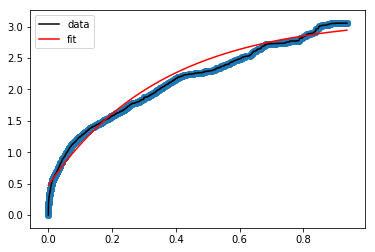

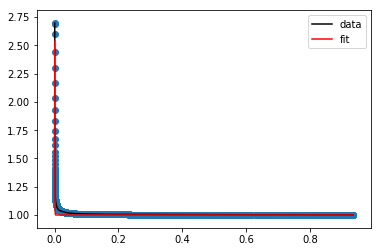

2.07016933157436 + 1.78449607545934e+157*exp(-5990.78319269151*(x + 0.245935649017906)**2) - 1.33334488034807*exp(-2.78866451746066*x)
-----------------
best eta: 0.0021732061805777433


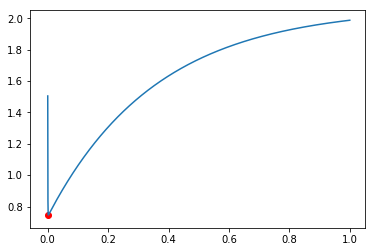

In [5]:
dataset='census13'
prediction_values,loss,t,mean_qerror=drawing(dataset,'original',estimator_name)
best_eta=fit_and_find_best_eta(prediction_values,t,mean_qerror,rate=0.5)
# test_for_best_eta(dataset,'original',best_eta,estimator_name)

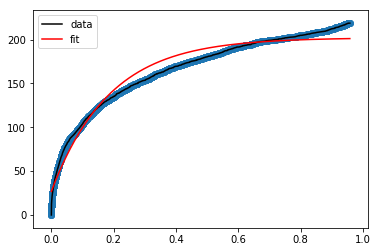

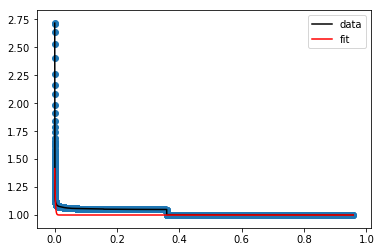

101.536321248495 + 1.97434245838093e+113*exp(-292.430153333606*(x + 0.947345213390318)**2) - 87.5685708976935*exp(-5.37091577370817*x)
-----------------
best eta: 0.0


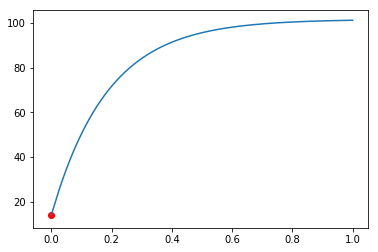

max: 462.9135254988914 99th: 21.930396825396866 95th: 8.0 90th: 5.0 75th: 2.25 50th: 1.1962784110006206 25th: 1.0406628201868213 mean: 2.7170875901777443
average incremental time: 0.005270600318908691 ms/query
turn_to_precise 42


In [6]:
dataset='forest10'
prediction_values,loss,t,mean_qerror=drawing(dataset,'original',estimator_name)
best_eta=fit_and_find_best_eta(prediction_values,t,mean_qerror,rate=0.5)
test_for_best_eta(dataset,'original',best_eta,estimator_name)

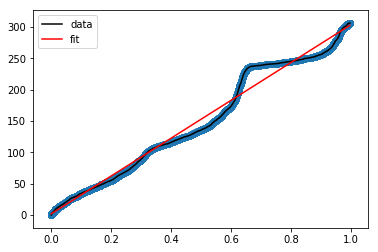

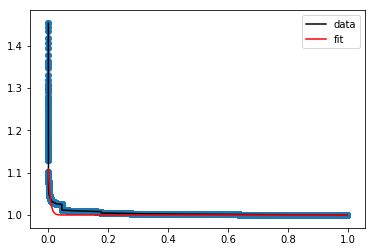

425693.376007653 + 1.07836285960178e+106*exp(-24.391295686835*(x + 3.18262143090345)**2) - 425691.839168041*exp(-0.000354559398470077*x)
-----------------
best eta: 1.0484484391781734e-09


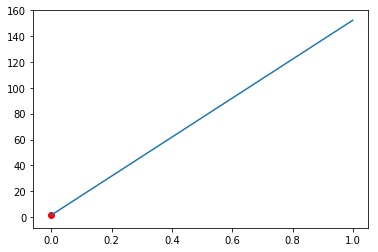

max: 279.0 99th: 10.750441176470598 95th: 2.2771292106586194 90th: 1.300734758841806 75th: 1.0409830141822183 50th: 1.0104696402596804 25th: 1.0035795934637548 mean: 1.4530723369091176
average incremental time: 0.0008162260055541992 ms/query
turn_to_precise 59


In [7]:
dataset='power7'
prediction_values,loss,t,mean_qerror=drawing(dataset,'original',estimator_name)
best_eta=fit_and_find_best_eta(prediction_values,t,mean_qerror,rate=0.5)
test_for_best_eta(dataset,'original',best_eta,estimator_name)

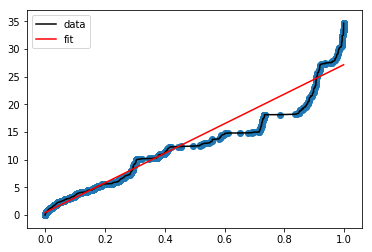

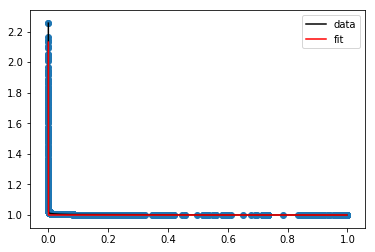

84576.3564489258 + 1.82480094278228e+91*exp(-18738233.8906566*(x + 0.00335331916794427)**2) - 84575.6287913868*exp(-0.000158021030564285*x)
-----------------
best eta: 0.0004951753423341053


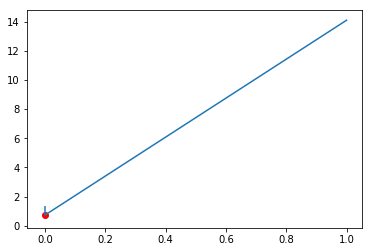

max: 18.979768786127167 99th: 1.191128417193587 95th: 1.0810217113582523 90th: 1.054671422506397 75th: 1.0272673388547375 50th: 1.0073301239579315 25th: 1.0 mean: 1.024441328294229
average incremental time: 0.2020932674407959 ms/query
turn_to_precise 2522


In [8]:
dataset='dmv11'
prediction_values,loss,t,mean_qerror=drawing(dataset,'original',estimator_name)
best_eta=fit_and_find_best_eta(prediction_values,t,mean_qerror,rate=0.5)
test_for_best_eta(dataset,'original',best_eta,estimator_name)